In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from skimage.feature import hog, local_binary_pattern
from skimage.morphology import skeletonize
from skimage.measure import label, regionprops
import cv2
import os
import matplotlib.pyplot as plt

In [3]:
def preprocess_image(image_path):
    # Load the image in grayscale mode
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply a 3x3 median filter for noise removal
    denoised_image = cv2.medianBlur(image, 3)

    # Apply Otsu's thresholding for binarization
    _, binarized_image = cv2.threshold(denoised_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return binarized_image 

In [4]:
def crop_center(img, cropx, cropy):
    y, x = img.shape
    startx = x // 2 - cropx // 2
    starty = y // 2 - cropy // 2
    return img[starty:starty + cropy, startx:startx + cropx]

def calculate_pixel_percentages(img, m=100):
    cropped_img = crop_center(img, m, m)
    black_pixels = np.sum(cropped_img < 128)
    white_pixels = np.sum(cropped_img >= 128)
    total_pixels = m * m
    percentage_black_pixels = (black_pixels / total_pixels) * 100
    percentage_white_pixels = (white_pixels / total_pixels) * 100

    return percentage_black_pixels, percentage_white_pixels
def calculate_line_irregularity(binary_img):
    # Ensure binary_img is of type uint8
    binary_img = binary_img.astype(np.uint8) * 255
    kernel = np.ones((5, 5), np.uint8)
    dilated_img = cv2.dilate(binary_img, kernel, iterations=1)

    # Calculate projection profile as a sum of pixels along each row
    projection = np.sum(dilated_img, axis=1)
    
    # Make projection 2-D for processing with label and regionprops
    projection_2d = np.expand_dims(projection, axis=1)

    # Basic peak detection
    peaks = projection_2d > np.mean(projection)
    labeled_peaks, num_features = label(peaks, return_num=True)
    props = regionprops(labeled_peaks)

    # Calculate the standard deviation of the line heights
    heights = [prop.bbox[2] - prop.bbox[0] for prop in props]  # Height is max_row - min_row
    line_irregularity = np.std(heights) if heights else 0

    return line_irregularity

def extract_features(image):
    # Binary image for pixel percentage calculation
    _, binary_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    edges = cv2.Canny(image, 100, 200)
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    hog_features, _ = hog(image, orientations=8, pixels_per_cell=(16, 16),
                          cells_per_block=(1, 1), visualize=True, feature_vector=True)
    
    numPoints = 24
    radius = 8
       # Local Binary Pattern
    lbp = local_binary_pattern(binary_img, numPoints, radius, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, numPoints + 3), range=(0, numPoints + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-7)  # Normalize

        
        # Combine HOG and LBP embeddings
    embedding = np.append(hog_features, lbp_hist)


    skeleton = skeletonize(binary_img > 0)
    endpoints = np.array((skeleton & np.roll(~skeleton, shift=1, axis=0)) |
                         (skeleton & np.roll(~skeleton, shift=-1, axis=0)) |
                         (skeleton & np.roll(~skeleton, shift=1, axis=1)) |
                         (skeleton & np.roll(~skeleton, shift=-1, axis=1)))
    num_endpoints = np.sum(endpoints)

    dist_transform = cv2.distanceTransform(binary_img, cv2.DIST_L2, 5)
    avg_thickness = np.mean(dist_transform)

    y, x = np.nonzero(sobel)
    angles = np.arctan2(sobely[y, x], sobelx[y, x])
    angle_diff = np.diff(angles)
    avg_curvature = np.mean(np.abs(angle_diff))

    percentage_black_pixels, percentage_white_pixels = calculate_pixel_percentages(binary_img, m=100)
    line_irregularity = calculate_line_irregularity(binary_img)

    avg_canny = np.mean(edges)
    avg_sobel = np.mean(sobel)
    avg_hog = np.mean(hog_features)

    return (avg_canny, avg_sobel, avg_hog, num_endpoints, avg_thickness, avg_curvature,
            percentage_black_pixels, percentage_white_pixels, line_irregularity, embedding.mean())

In [5]:
df = pd.read_csv('student_features.csv')
df.head()

filtered_df = df[df['Image Name'].str.contains('pLND')]

filtered_df.head()

# List of student IDs to keep
students_to_keep = ['student_4', 'student_23', 'student_22', 'student_20', 'student_34']

# Filter rows based on the 'Student' column using isin() and boolean indexing
df = filtered_df[filtered_df['Student'].isin(students_to_keep)]
# MOST VARYING STUDENTS: STUDENT_22 STUDENT_4 STUDENT_20 STUDENT_23 STUDENT_34

df.to_csv('filtered_students.csv', index=False)

Epoch 1/2000
1/1 [==============================] - 0s 348ms/step - loss: 2.8398 - accuracy: 0.0000e+00 - val_loss: 2.5592 - val_accuracy: 0.3333
Epoch 2/2000
1/1 [==============================] - 0s 18ms/step - loss: 2.5969 - accuracy: 0.1111 - val_loss: 2.5238 - val_accuracy: 0.3333
Epoch 3/2000
1/1 [==============================] - 0s 17ms/step - loss: 2.7019 - accuracy: 0.1111 - val_loss: 2.4854 - val_accuracy: 0.6667
Epoch 4/2000
1/1 [==============================] - 0s 18ms/step - loss: 2.4938 - accuracy: 0.3333 - val_loss: 2.4479 - val_accuracy: 0.6667
Epoch 5/2000
1/1 [==============================] - 0s 18ms/step - loss: 2.6674 - accuracy: 0.1111 - val_loss: 2.4112 - val_accuracy: 0.6667
Epoch 6/2000
1/1 [==============================] - 0s 17ms/step - loss: 2.6598 - accuracy: 0.0000e+00 - val_loss: 2.3767 - val_accuracy: 0.6667
Epoch 7/2000
1/1 [==============================] - 0s 17ms/step - loss: 2.5982 - accuracy: 0.3333 - val_loss: 2.3455 - val_accuracy: 0.6667
Epoc

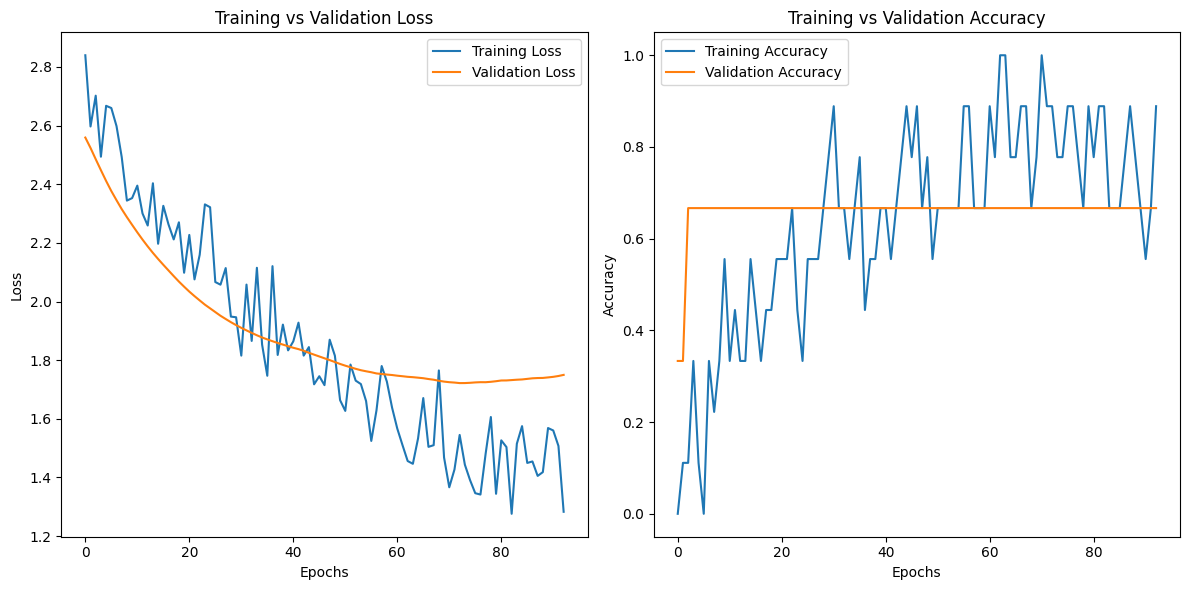

1/1 [==============================] - 0s 14ms/step - loss: 1.9805 - accuracy: 0.0000e+00
Test accuracy: 0.0


In [12]:
# Assuming 'Student' is the label and the rest are features
X = df.drop(['Student', 'Image Name'], axis=1)
y = df['Student']

# Encode the categorical labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build a neural network model with dropout and L2 regularization
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(set(y_encoded)), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping criteria
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Fit the model on the training data
history = model.fit(X_train_scaled, y_train, epochs=2000, validation_split=0.2, callbacks=[early_stopping])

# Plot the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print('Test accuracy:', test_acc)
model.save('trained_model.h5')


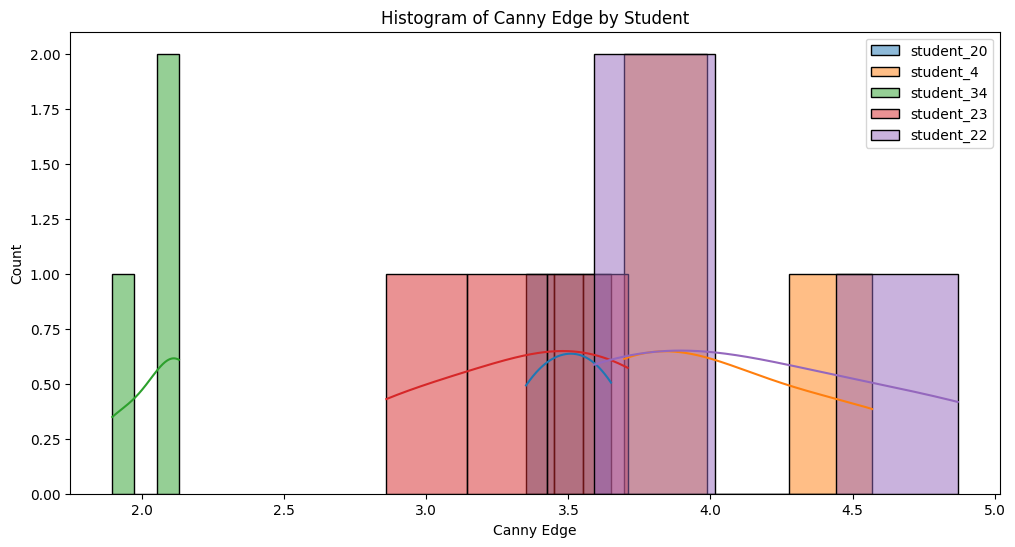

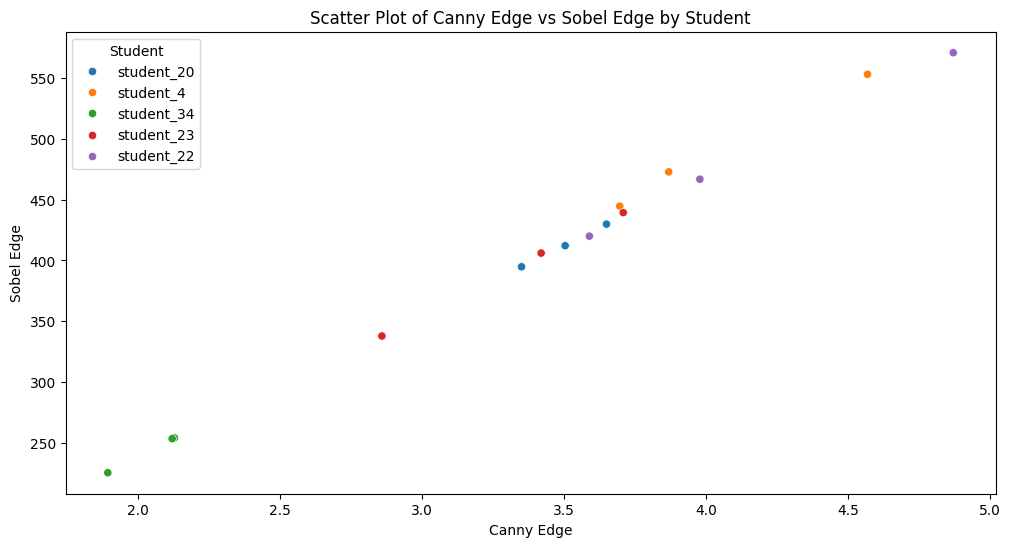

In [14]:
import seaborn as sns

test = pd.read_csv('filtered_students.csv')
# Create a histogram with different colors for each student
plt.figure(figsize=(12, 6))
students = test['Student'].unique()
for student in students:
    sns.histplot(test[test['Student'] == student]['Canny Edge'], kde=True, label=str(student))
plt.title('Histogram of Canny Edge by Student')
plt.legend()
plt.show()

# Scatter plot for "Canny Edge" vs "Sobel Edge" with points colored by student
plt.figure(figsize=(12, 6))
sns.scatterplot(data=test, x='Canny Edge', y='Sobel Edge', hue='Student')
plt.title('Scatter Plot of Canny Edge vs Sobel Edge by Student')
plt.show()


In [6]:
def predict_author(features, model, scaler, label_encoder):
    # Convert the features tuple to a 2D array and scale it
    features_array = np.array([features])
    features_scaled = scaler.transform(features_array)
    
    # Use the model to predict probabilities
    probabilities = model.predict(features_scaled)[0]
    
    # Get the indices of the top 10 probabilities
    top_indices = np.argsort(probabilities)[-5:][::-1]
    
    # Get the corresponding student labels and probabilities
    top_students = label_encoder.inverse_transform(top_indices)
    top_probabilities = probabilities[top_indices]
    
    # Format and return the results
    return [(student, prob) for student, prob in zip(top_students, top_probabilities)]

In [7]:
def predict_and_score(features, true_author, model, scaler, label_encoder):
    # Predict the author based on the features
    predictions = predict_author(features, model, scaler, label_encoder)
    predicted_labels, probabilities = zip(*predictions)

    # Find the rank of the true author in the predictions
    if true_author in predicted_labels:
        rank = predicted_labels.index(true_author) + 1  # Get the rank (1-based indexing)
    else:
        rank = None  # Not in the top 10

    points = (6 - rank) / 5  # Score equivalent to the placement (1st place = 1.0, 2nd place = 0.9, etc.)

    return points, rank, predictions

directory = 'test_images'

total_accuracy = 0.0
accuracy_score = 0.0
count = 1
# Loop through each folder in the directory
for folder_name in os.listdir(directory):
    true_author = folder_name
    folder_path = os.path.join(directory, folder_name)
    # Check if the item in the directory is a folder
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            image_path = 'test_images/' + true_author + '/' + filename
            image = preprocess_image(image_path)
            features_tuple = extract_features(image)
            print("TRUE AUTHOR IS: ", true_author)
            points, rank, predictions = predict_and_score(features_tuple, true_author, model, scaler, label_encoder)
            print(f"Points awarded: {points}, Rank: {rank}")
            for student, probability in predictions:
                print(f"{student} has a {probability * 100:.2f}% chance of being the author")
            total_accuracy += points
            accuracy_score = total_accuracy / count
            count += 1
            print(accuracy_score)

TRUE AUTHOR IS:  student_20
1/1 [==============================] - 0s 39ms/step
Points awarded: 1.0, Rank: 1
student_20 has a 47.08% chance of being the author
student_22 has a 18.18% chance of being the author
student_23 has a 15.77% chance of being the author
student_34 has a 10.29% chance of being the author
student_4 has a 8.68% chance of being the author
1.0


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_20
1/1 [==============================] - 0s 17ms/step
Points awarded: 1.0, Rank: 1
student_20 has a 54.58% chance of being the author
student_23 has a 19.96% chance of being the author
student_22 has a 12.33% chance of being the author
student_34 has a 7.90% chance of being the author
student_4 has a 5.23% chance of being the author
1.0


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_20
1/1 [==============================] - 0s 10ms/step
Points awarded: 1.0, Rank: 1
student_20 has a 49.97% chance of being the author
student_22 has a 17.56% chance of being the author
student_23 has a 15.65% chance of being the author
student_34 has a 9.28% chance of being the author
student_4 has a 7.55% chance of being the author
1.0


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_20
1/1 [==============================] - 0s 13ms/step
Points awarded: 1.0, Rank: 1
student_20 has a 53.76% chance of being the author
student_23 has a 15.74% chance of being the author
student_34 has a 14.09% chance of being the author
student_22 has a 10.59% chance of being the author
student_4 has a 5.82% chance of being the author
1.0


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_20
1/1 [==============================] - 0s 11ms/step
Points awarded: 1.0, Rank: 1
student_20 has a 59.36% chance of being the author
student_23 has a 21.85% chance of being the author
student_22 has a 10.85% chance of being the author
student_34 has a 5.29% chance of being the author
student_4 has a 2.65% chance of being the author
1.0


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_20
1/1 [==============================] - 0s 16ms/step
Points awarded: 1.0, Rank: 1
student_20 has a 56.55% chance of being the author
student_23 has a 20.27% chance of being the author
student_22 has a 9.53% chance of being the author
student_34 has a 9.49% chance of being the author
student_4 has a 4.15% chance of being the author
1.0


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_22
1/1 [==============================] - 0s 18ms/step
Points awarded: 1.0, Rank: 1
student_22 has a 38.90% chance of being the author
student_4 has a 32.34% chance of being the author
student_20 has a 13.25% chance of being the author
student_23 has a 10.49% chance of being the author
student_34 has a 5.01% chance of being the author
1.0


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_22
1/1 [==============================] - 0s 11ms/step
Points awarded: 0.8, Rank: 2
student_4 has a 41.82% chance of being the author
student_22 has a 40.01% chance of being the author
student_20 has a 7.41% chance of being the author
student_23 has a 6.72% chance of being the author
student_34 has a 4.03% chance of being the author
0.975


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_22
1/1 [==============================] - 0s 11ms/step
Points awarded: 0.8, Rank: 2
student_4 has a 64.13% chance of being the author
student_22 has a 30.50% chance of being the author
student_20 has a 2.08% chance of being the author
student_23 has a 1.69% chance of being the author
student_34 has a 1.59% chance of being the author
0.9555555555555555


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_22
1/1 [==============================] - 0s 11ms/step
Points awarded: 0.8, Rank: 2
student_4 has a 57.95% chance of being the author
student_22 has a 35.18% chance of being the author
student_20 has a 2.66% chance of being the author
student_23 has a 2.28% chance of being the author
student_34 has a 1.93% chance of being the author
0.9400000000000001


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_22
1/1 [==============================] - 0s 10ms/step
Points awarded: 1.0, Rank: 1
student_22 has a 44.67% chance of being the author
student_4 has a 37.52% chance of being the author
student_20 has a 7.00% chance of being the author
student_23 has a 6.82% chance of being the author
student_34 has a 4.00% chance of being the author
0.9454545454545454


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_22
1/1 [==============================] - 0s 10ms/step
Points awarded: 0.8, Rank: 2
student_4 has a 41.10% chance of being the author
student_22 has a 39.51% chance of being the author
student_20 has a 7.13% chance of being the author
student_23 has a 7.12% chance of being the author
student_34 has a 5.14% chance of being the author
0.9333333333333335


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_23
1/1 [==============================] - 0s 10ms/step
Points awarded: 0.8, Rank: 2
student_20 has a 65.06% chance of being the author
student_23 has a 14.16% chance of being the author
student_22 has a 10.18% chance of being the author
student_34 has a 6.27% chance of being the author
student_4 has a 4.34% chance of being the author
0.9230769230769232


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_23
1/1 [==============================] - 0s 11ms/step
Points awarded: 0.8, Rank: 2
student_22 has a 50.75% chance of being the author
student_23 has a 19.37% chance of being the author
student_20 has a 16.78% chance of being the author
student_4 has a 10.03% chance of being the author
student_34 has a 3.07% chance of being the author
0.9142857142857145


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_23
1/1 [==============================] - 0s 10ms/step
Points awarded: 0.6, Rank: 3
student_22 has a 36.17% chance of being the author
student_20 has a 31.01% chance of being the author
student_23 has a 24.58% chance of being the author
student_4 has a 5.20% chance of being the author
student_34 has a 3.04% chance of being the author
0.8933333333333334


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_23
1/1 [==============================] - 0s 11ms/step
Points awarded: 0.6, Rank: 3
student_22 has a 32.38% chance of being the author
student_20 has a 28.93% chance of being the author
student_23 has a 21.83% chance of being the author
student_4 has a 10.07% chance of being the author
student_34 has a 6.79% chance of being the author
0.8750000000000001


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_23
1/1 [==============================] - 0s 10ms/step
Points awarded: 0.6, Rank: 3
student_22 has a 39.28% chance of being the author
student_20 has a 24.74% chance of being the author
student_23 has a 23.86% chance of being the author
student_4 has a 8.33% chance of being the author
student_34 has a 3.79% chance of being the author
0.8588235294117648


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_23
1/1 [==============================] - 0s 11ms/step
Points awarded: 0.8, Rank: 2
student_20 has a 37.40% chance of being the author
student_23 has a 30.62% chance of being the author
student_22 has a 21.52% chance of being the author
student_4 has a 5.39% chance of being the author
student_34 has a 5.07% chance of being the author
0.8555555555555556


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_34
1/1 [==============================] - 0s 11ms/step
Points awarded: 1.0, Rank: 1
student_34 has a 95.43% chance of being the author
student_20 has a 3.16% chance of being the author
student_23 has a 0.79% chance of being the author
student_22 has a 0.43% chance of being the author
student_4 has a 0.19% chance of being the author
0.8631578947368422


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_34
1/1 [==============================] - 0s 11ms/step
Points awarded: 1.0, Rank: 1
student_34 has a 93.10% chance of being the author
student_20 has a 4.53% chance of being the author
student_23 has a 1.29% chance of being the author
student_22 has a 0.70% chance of being the author
student_4 has a 0.37% chance of being the author
0.8700000000000001


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_34
1/1 [==============================] - 0s 11ms/step
Points awarded: 1.0, Rank: 1
student_34 has a 89.22% chance of being the author
student_20 has a 6.92% chance of being the author
student_23 has a 2.03% chance of being the author
student_22 has a 1.23% chance of being the author
student_4 has a 0.60% chance of being the author
0.8761904761904763


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_34
1/1 [==============================] - 0s 11ms/step
Points awarded: 1.0, Rank: 1
student_34 has a 88.82% chance of being the author
student_20 has a 7.43% chance of being the author
student_23 has a 2.05% chance of being the author
student_22 has a 1.12% chance of being the author
student_4 has a 0.58% chance of being the author
0.881818181818182


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_34
1/1 [==============================] - 0s 10ms/step
Points awarded: 1.0, Rank: 1
student_34 has a 92.91% chance of being the author
student_20 has a 5.17% chance of being the author
student_23 has a 1.16% chance of being the author
student_22 has a 0.51% chance of being the author
student_4 has a 0.25% chance of being the author
0.8869565217391305


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_34
1/1 [==============================] - 0s 10ms/step
Points awarded: 1.0, Rank: 1
student_34 has a 88.58% chance of being the author
student_20 has a 7.38% chance of being the author
student_23 has a 2.07% chance of being the author
student_22 has a 1.37% chance of being the author
student_4 has a 0.60% chance of being the author
0.8916666666666667


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_4
1/1 [==============================] - 0s 10ms/step
Points awarded: 1.0, Rank: 1
student_4 has a 79.15% chance of being the author
student_22 has a 18.96% chance of being the author
student_20 has a 0.80% chance of being the author
student_23 has a 0.79% chance of being the author
student_34 has a 0.30% chance of being the author
0.8960000000000001


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_4
1/1 [==============================] - 0s 11ms/step
Points awarded: 1.0, Rank: 1
student_4 has a 80.73% chance of being the author
student_22 has a 18.71% chance of being the author
student_23 has a 0.23% chance of being the author
student_20 has a 0.18% chance of being the author
student_34 has a 0.15% chance of being the author
0.9000000000000001


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_4
1/1 [==============================] - 0s 10ms/step
Points awarded: 1.0, Rank: 1
student_4 has a 83.63% chance of being the author
student_22 has a 15.54% chance of being the author
student_23 has a 0.33% chance of being the author
student_20 has a 0.26% chance of being the author
student_34 has a 0.24% chance of being the author
0.9037037037037038


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_4
1/1 [==============================] - 0s 11ms/step
Points awarded: 1.0, Rank: 1
student_4 has a 87.89% chance of being the author
student_22 has a 11.77% chance of being the author
student_23 has a 0.14% chance of being the author
student_20 has a 0.11% chance of being the author
student_34 has a 0.09% chance of being the author
0.9071428571428573


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_4
1/1 [==============================] - 0s 11ms/step
Points awarded: 1.0, Rank: 1
student_4 has a 80.80% chance of being the author
student_22 has a 17.07% chance of being the author
student_23 has a 0.83% chance of being the author
student_20 has a 0.74% chance of being the author
student_34 has a 0.56% chance of being the author
0.9103448275862069


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TRUE AUTHOR IS:  student_4
1/1 [==============================] - 0s 10ms/step
Points awarded: 0.8, Rank: 2
student_22 has a 48.21% chance of being the author
student_4 has a 47.03% chance of being the author
student_23 has a 1.94% chance of being the author
student_20 has a 1.84% chance of being the author
student_34 has a 0.98% chance of being the author
0.9066666666666667


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Files in folder "student_20":
w0020_s02_pLND_r01.png
w0020_s02_pLND_r02.png
w0020_s02_pLND_r03.png
w0020_s03_pLND_r01.png
w0020_s03_pLND_r02.png
w0020_s03_pLND_r03.png
Files in folder "student_22":
w0022_s02_pLND_r01.png
w0022_s02_pLND_r02.png
w0022_s02_pLND_r03.png
w0022_s03_pLND_r01.png
w0022_s03_pLND_r02.png
w0022_s03_pLND_r03.png
Files in folder "student_23":
w0023_s02_pLND_r01.png
w0023_s02_pLND_r02.png
w0023_s02_pLND_r03.png
w0023_s03_pLND_r01.png
w0023_s03_pLND_r02.png
w0023_s03_pLND_r03.png
Files in folder "student_34":
w0034_s02_pLND_r01.png
w0034_s02_pLND_r02.png
w0034_s02_pLND_r03.png
w0034_s03_pLND_r01.png
w0034_s03_pLND_r02.png
w0034_s03_pLND_r03.png
Files in folder "student_4":
w0004_s02_pLND_r01.png
w0004_s02_pLND_r02.png
w0004_s02_pLND_r03.png
w0004_s03_pLND_r01.png
w0004_s03_pLND_r02.png
w0004_s03_pLND_r03.png


In [81]:
preprocessed_image = preprocess_image('student_30.png')
features_tuple = extract_features(preprocessed_image)


# Predict the author based on the features
author_predictions = predict_author(features_tuple, model, scaler, label_encoder)

# Display the top 10 predictions
for student, probability in author_predictions:
    print(f"{student} has a {probability * 100:.2f}% chance of being the author")


1/1 [==============================] - 0s 12ms/step
student_30 has a 32.28% chance of being the author
student_16 has a 20.07% chance of being the author
student_33 has a 13.08% chance of being the author
student_34 has a 7.79% chance of being the author
student_35 has a 6.66% chance of being the author
student_25 has a 3.39% chance of being the author
student_13 has a 3.03% chance of being the author
student_18 has a 2.26% chance of being the author
student_31 has a 1.98% chance of being the author
student_2 has a 1.94% chance of being the author


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [82]:
preprocessed_image = preprocess_image('student_33.png')
features_tuple = extract_features(preprocessed_image)


# Predict the author based on the features
author_predictions = predict_author(features_tuple, model, scaler, label_encoder)

# Display the top 10 predictions
for student, probability in author_predictions:
    print(f"{student} has a {probability * 100:.2f}% chance of being the author")


1/1 [==============================] - 0s 11ms/step
student_33 has a 16.73% chance of being the author
student_30 has a 15.18% chance of being the author
student_16 has a 14.27% chance of being the author
student_18 has a 8.29% chance of being the author
student_35 has a 7.56% chance of being the author
student_25 has a 6.28% chance of being the author
student_13 has a 4.56% chance of being the author
student_5 has a 3.67% chance of being the author
student_34 has a 3.66% chance of being the author
student_43 has a 2.31% chance of being the author


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [83]:
preprocessed_image = preprocess_image('student_35.png')
features_tuple = extract_features(preprocessed_image)


# Predict the author based on the features
author_predictions = predict_author(features_tuple, model, scaler, label_encoder)

# Display the top 10 predictions
for student, probability in author_predictions:
    print(f"{student} has a {probability * 100:.2f}% chance of being the author")


1/1 [==============================] - 0s 11ms/step
student_35 has a 50.13% chance of being the author
student_25 has a 14.09% chance of being the author
student_33 has a 13.65% chance of being the author
student_13 has a 10.69% chance of being the author
student_18 has a 7.31% chance of being the author
student_27 has a 1.04% chance of being the author
student_16 has a 0.76% chance of being the author
student_4 has a 0.67% chance of being the author
student_38 has a 0.41% chance of being the author
student_42 has a 0.35% chance of being the author


c:\Users\Arnav\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
